# Audio Summary Generation: Step by Step 
## Geoffroy Peeters - 2018/10

# Introduction

The goal is to create a system that allows the automatic generation of an audio summary from the analysis of the audio signal.
- the input to the system is the audio file (.wav) of a music track
- the output is another audio file (.wav) that summarizes the content of the input in 20 seconds.

The method we will use is the "summary score" proposed by [Cooper and Foote, ISMIR 2002].
The difference with the original paper (which uses MFCCs as audio observation) is the use of Chroma as observation.

In practice, you are asked to fill in the part between ### START CODE HERE ### and ### END CODE HERE ### to complete the system.

The system is splitted into the following steps:

- 1) read an audio file
- 2) compute observations from the audio file at each time (a.k.a. audio features or hand-crafted features). We will use the Chroma as audio features.
    - 2a) we first need to compute the Short-Time-Fourier-Transform (spectrogram)
    - 2b) create a set of filters that allows to map the STFT to the Chroma space
    - 2c) use these filters to map the STFT to the Chroma space
- 3) compute the Self-Similarity-Matrix of the Chromagram
- 4) compute the "summary score" of the SSM and chooses its maximum value as starting point of the audio summary
- 5) write an audio file

# Packages

We first import the set of necessay packages

In [1]:
import numpy as np
import scipy.io.wavfile
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import tpt_tools
%matplotlib inline

# 1) Read an audio file

In [2]:
audioFile = './audio_gammepno.wav'
#audioFile = './audio_joe.wav'

sr_hz, data_v = scipy.io.wavfile.read(audioFile)
print(sr_hz)

44100


### Define the parameters of system and convert them according to the sampling rate of the audio track

In [3]:
# --- STFT window duration
L_sec = 0.2
# --- STFT hop-size
STEP_sec = 0.2/3
# --- define the duration of the summary
duration_sec = 20

# 2) Compute Chromagram from audio signal

## 2a) Compute Short Time Fourier Transform

We first perform the short term analysis using DFT  (a.k.a. Short Time Fourier Transform) using a blackman analysis window of duration 0.2s and hop size 0.2/3s.

The conversion from seconds to samples is
- L_n=round(0.2 * sr_hz) et
- STEP_n=round(0.2/3 * sr_hz)
- in which sr_hz is the sampling rate (which depends on the audio file).

The FFT size $N$ should be larger or equal to the window duration L_n. 
It should be power of 2 in order to be able to use the Fast Fourier Transform algorithm (FFT). 
We will use a zero-padding factor of 4 for $N$ which means we will take 4 times the value of $N$ which is the first power 2 larger than L_n.
This zero-padding will help us creating the chroma filters for the lowest frequencies.

In [4]:
# --- Convert values from seconds (_sec) to samples (_n)
L_n = int(np.round(L_sec * sr_hz))
STEP_n = int(np.round(STEP_sec*sr_hz))
# --- Compute the DFT size using zero-padding
N = 4*tpt_tools.nextpow2(L_n)


At each frame, we 
- window the signal
- compute its DFT
- store the results in a matrix

In [5]:
def F_getSTFT(data_v, sr_hz, L_n, STEP_n):
    """
    inputs:
        - data_v: audio signal
        - sr_hz: sampling rate
        - L_n: window duration
        - STEP_n: hope size
    outputs:
        - amFft_m (N/2+1, nbFrame)
        - freqTF_hz_v (N/2+1, )
        - T_sec_v (nbFrame, )
    """
    ### START CODE HERE ###
    
    nbFrame = len(data_v)//STEP_n

    while nbFrame*STEP_n + L_n > len(data_v):
        nbFrame -= 1
    
    N = 4*tpt_tools.nextpow2(L_n)
    
    amFft_m = np.zeros(((N//2)+1, nbFrame))
    
    T_sec_v = np.zeros(nbFrame)
     
    for step in tqdm(range(nbFrame)):
        
        T_sec_v[step] = step*STEP_n/sr_hz
        
        window = data_v[step*STEP_n:step*STEP_n+L_n]*np.blackman(L_n)
        
        sp = np.fft.fft(window, n = N)
        sp = sp[0:(N//2)+1]
        sp = [np.sqrt(sp.real[i]**2+sp.imag[i]**2) for i in range(len(sp))]
    
        amFft_m[:,step] = sp   
        
    
    freqTF_hz_v = abs(np.fft.fftfreq(N)[0:N//2+1]*sr_hz)
    
    #amFft_m = amFft_m.transpose()
    ### END CODE HERE ###
    
    return amFft_m, freqTF_hz_v, T_sec_v


### Test the function

When ```audioFile = './audio_gammepno.wav'```
you should obtain the following figure
<img src="./_images/TPstruct_01.png" width=400/>

In [6]:
amFft_m, freqTF_hz_v, T_sec_v = F_getSTFT(data_v, sr_hz, L_n, STEP_n)

print(N)
print(amFft_m.shape)
print(freqTF_hz_v.shape)
print(T_sec_v.shape)

100%|██████████| 192/192 [00:37<00:00,  5.09it/s]

65536
(32769, 192)
(32769,)
(192,)
[0.00000000e+00 6.72912598e-01 1.34582520e+00 ... 2.20486542e+04
 2.20493271e+04 2.20500000e+04]


When ```audioFile = './_audio/audio_gammepno.wav'```, you should obtain the following values

```(65536)
(32769, 192)
(32769,)
(192,)```

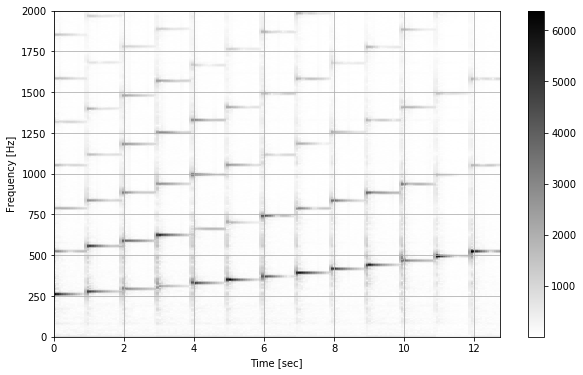

In [8]:
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(np.sqrt(amFft_m), freqTF_hz_v, T_sec_v, 'Frequency [Hz]', 'Time [sec]')
plt.ylim((0,2000));

## 2b) Create the matrix containing the filters

There is 12 Chromas (or Pitch Class Profile). We denote them by ```c```.

For each chroma ```c```, we will create a specific filter that perform the mapping between the values of the DFT and this specific chroma.

We denote by ```n```, the semi-tone-pitches (or midi notes). For example ```n=69``` is A-4 or 440Hz.
The chroma ```c``` corresponding to a given semi-note ```n``` is given by ```c = mod(n, 12)```.
The chroma ```c``` should therefore represents the energy existing in the DFT at all semi-pitches ```n``` such that ```c = mod(n, 12)```.

For each of these ```n```, we will create a band-pass filter centered on $n$ and extending on the left to ```n-1``` and the right to ```n+1```.

Each band-pass filter is normalized such that it sums to 1.

To create the filters we can use the following formula which maps the DFT frequency ```freqTF_hz_v```to the corresponding midi notes ```freqTF_midi_v```
: ```freqTF_midi_v = 12 * log2(freqTF_hz_v / 440)+69```.

The shape of the filter will be defined by the following formula:
$H = \frac{1}{2} \tanh(\pi (1-2x))+\frac{1}{2}$ in which $x$ represents the absolute value of the distance between ```n``` and ```freqTF_midi_v```: ```x = abs(n - freqTF_midi_v)```.

We will only consider the MIDI notes ```n=36```, ```n=37``` to ```n=119```.

The 12 chroma filters are stored in a matrix ```(12, N/2+1)```, i.e. one filter per row.

In [12]:
def F_getChromaFiltre(freqTF_hz_v, startMidi=36, endMidi=119):
    """
    inputs:
        - freqTF_hz_v (N/2+1): frequency axis of the DFT in Hz
        - startMidi: starting midi note (int)
        - endMidi: ending midi note (int)
    outputs:
        - chromaFiltre_m (12, N/2+1)
        - midi_v (nbMidi)
    """
    
    ### START CODE HERE ###
    
        
    freqTF_midi_v = 12 * np.log2(abs(freqTF_hz_v) / 440)+69

    chromaFiltre_m = np.zeros((12, len(freqTF_hz_v)))
    
    for n in tqdm(range(startMidi, startMidi+12)):
        for i in range((endMidi- n)//12):
            x = abs(n+(i*12)-freqTF_midi_v)
            H = 0.5*np.tanh(np.pi*(1-2*x)) + 0.5
            chromaFiltre_m[n-startMidi] += H/np.sum(H)  
            
            
    midi_v = []
    
    for i in range(startMidi, endMidi+1):
        midi_v.append(i)
    midi_v = np.asarray(midi_v)
    
    ### END CODE HERE ###
    
    return chromaFiltre_m, midi_v

### Test the function

You should obtain the following figure
<img src="./_images/TPstruct_02.png" width=400/>

In [13]:
chromaFiltre_m, midi_v = F_getChromaFiltre(freqTF_hz_v)

print(chromaFiltre_m.shape)
print(midi_v.shape)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
100%|██████████| 12/12 [00:00<00:00, 237.46it/s]

(12, 32769)
(84,)


 You should obtain the following values
 
 ```(12, 32769)
(84,)```

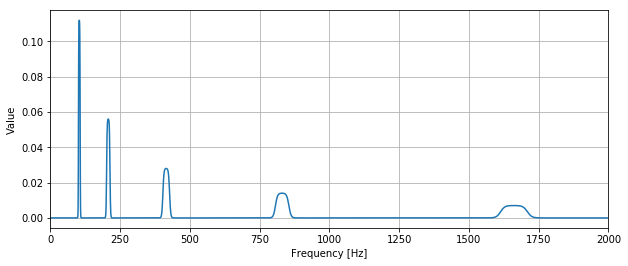

In [15]:
plt.figure(figsize=(10, 4))
tpt_tools.F_plot1(freqTF_hz_v, chromaFiltre_m[8,:], 'Frequency [Hz]', 'Value')
plt.xlim((0,2000));

### Display all the filters as a matrix

You should obtain the following figure
<img src="./_images/TPstruct_03.png" width=400/>

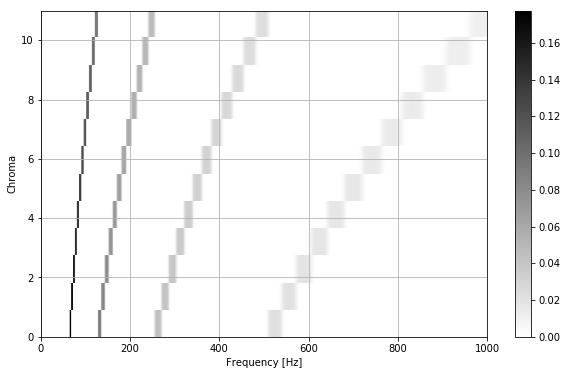

In [16]:
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(chromaFiltre_m, np.arange(0, 12), freqTF_hz_v, 'Chroma', 'Frequency [Hz]')
plt.xlim((0,1000));

## 2c) Compute the Chromagram

To obtain the Chromagram, we simply multiply (matrix multiplication) the Chroma matrix with the STFT matrix:
(12, N/2+1) * (N/2+1, nbFrame) = (12, nbFrame). 

The output of this is a matrix in which the rows represent the 12 values of the chroma and the column the successive time frames.



### Test the function

In [17]:
chromaGram_m = np.dot(chromaFiltre_m, amFft_m)

print(chromaFiltre_m.shape)
print(amFft_m.shape)
print(chromaGram_m.shape)

(12, 32769)
(32769, 192)
(12, 192)


When ```audioFile = './audio_gammepno.wav'```, you should obtain the following values

```(12, 32769)
(32769, 192)
(12, 192)```

### Display the chromagram

When ```audioFile = './_audio/audio_gammepno.wav````, you should obtain the following figure
<img src="./_images/TPstruct_04.png" width=400/>

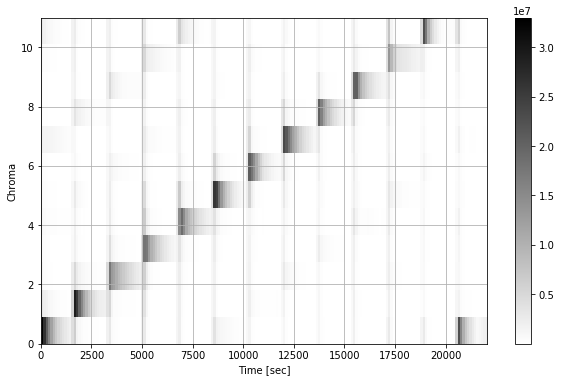

In [18]:
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(chromaGram_m, np.arange(0, 12), freqTF_hz_v, 'Chroma', 'Time [sec]')

# 3. Compute the Self-Similarity-Matrix (time,time) using the Chromagram

We now compute the Self-Similarity-Matrix (SSM) using the Chromagram.
An entry $(i,j)$ in the SSM represent the similarity between time $t_i$ and time $t_j$.

For this, we will use the ```1 - (cosine distance)``` between the chroma vector at time $t_i$ and the one at $t_j$.


The ```1 - ( cosine distance)```
 between $x$ and $x$ is defined as
$dist(x,y)=\frac{\sum_k x(i) y(i)}{\sqrt{\sum_i x(i)^2} \sqrt{\sum_i x(i)^2}}$

In [19]:
def F_getSsmTT(data_m):
    """
    inputs:
        - data_m (12, nbFrame)
    outputs:
        - ssmTT_m (nbFrame, nbFrame)
    """
    
    ### START CODE HERE ###
    norm_v = np.sqrt(np.sum(data_m ** 2, axis=0) + sys.float_info.epsilon)
    # norm_m (12, nbFrame)
    norm_m = np.tile(norm_v, (12, 1))
    data_m = np.divide(data_m, norm_m)

    ssmTT_m = np.dot(data_m.T,  data_m)
    ### END CODE HERE ###
    
    return ssmTT_m

### Test the function

When audioFile = './audio_gammepno.wav', you should obtain the following figure
<img src="./_images/TPstruct_05.png" width=400/>

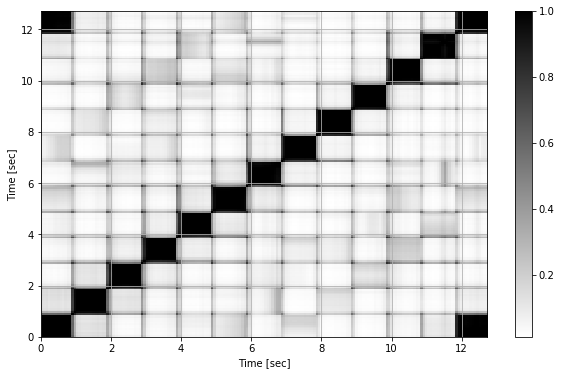

In [20]:
ssmTT_m = F_getSsmTT(chromaGram_m)
# --- In order to emphasize the sequences (sub-diagonal) existing 

if False:
    # --- in the matrix we cancel the values below a threshold
    ssmTT_m[ssmTT_m<0.97]=0

# --- Display the matrix
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(ssmTT_m, T_sec_v, T_sec_v, 'Time [sec]', 'Time [sec]')

# 4) Compute the "summary score" of the SSM and chooses its maximum value as starting point of the audio summary

Using the SSM, we look to the best starting point in the music track of a 20s segment such that this segment best represent (is the most similar to) the whole content of the track.

For this, we compute the "summary score" proposed by [Cooper, Foote, 2002]:
- For each time q (row q in the matrix), the summary score is computed as the sum over the column of the matrix for this row. It represents the similarity between time q and the rest of the track.
- For a segment starting at q and of duration L, the summary score is compute as the sum over the column inside q and q+L. It represents the the similarity between the segment [q,q+L] and the rest of the track.
- L is imposed as the length of the audio summary
- We look for the best summary of 20s. We therefore look for the value of q which maximizes the score.

In [17]:
def F_getSummaryScore(ssm_m, duration_frame):
    """
    inputs:
        - ssm_m (nbFrame, nbFrame)
        - duration_frame
    outputs:
        - startPos_frame
        - score_v (nbFrame)
    """
    
    ### START CODE HERE ###

    ### END CODE HERE ###
    
    return startPos_frame, score_v

### Test the function

In [18]:
# --- convert it to number of frames
duration_frame, duration_n = int(duration_sec/STEP_sec), int(duration_sec*sr_hz)
print("Duration sec:{} samples:{} frames:{}".format(duration_sec, duration_n, duration_frame))
startPos_frame, score_v = F_getSummaryScore(ssmTT_m, duration_frame)
startPos_sec, startPos_n = startPos_frame*STEP_sec, int(startPos_frame*STEP_sec*sr_hz)

Duration sec:20 samples:882000 frames:300


NameError: name 'ssmTT_m' is not defined

### Display the resuting score function and estimated starting point of the audio summary

In [19]:
plt.figure(figsize=(10, 6))
tpt_tools.F_plot1(np.arange(0, len(score_v)), score_v, 'frame', 'score')
plt.plot(startPos_frame, score_v[startPos_frame], 'ro')
print("Start sec:{}, samples:{} frames:{}".format(startPos_sec, startPos_n, startPos_frame))

NameError: name 'score_v' is not defined

<Figure size 720x432 with 0 Axes>

In [20]:
plt.figure(figsize=(15, 12))
tpt_tools.F_plot2(ssmTT_m, T_sec_v, T_sec_v, 'Time [sec]', 'Time [sec]')
plt.plot(startPos_sec, startPos_sec, 'ro')
plt.plot(startPos_sec+duration_sec, startPos_sec+duration_sec, 'ro')

NameError: name 'ssmTT_m' is not defined

<Figure size 1080x864 with 0 Axes>

# 5) Generate the audio summary

The audio summary is then simply the segment starting at ```startPos``` and of duration ```duration```.

In [213]:
scipy.io.wavfile.write(audioFile.replace('.wav', '-summary.wav'), sr_hz, data_v[startPos_n:startPos_n+duration_n])